In [10]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from pathlib import Path
import os
import shutil

In [2]:
def custom_plot(img, mask, title=None, size=10):
    """Plots image and mask"""
    fig = plt.figure(figsize=(size, 4))
    if title:
        fig.suptitle(f'{title}')
    ax = fig.subplots(1, 2)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(img)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].imshow(mask)
    fig.tight_layout()
    plt.show()

### Generation of crop dataset (train)

In [24]:
# catalog to save results
save_cat = Path('/home/ezhur/datasets/projects/satellite_datasets/')

# orig dataset catalog
cat = Path('/home/ezhur/datasets/projects/train_updated_titles/train_updated_titiles')
img_folder = cat / 'images'
mask_folder = cat / 'masks'


for num in range(0, 21): # num of orig samples
    num = f'{num:03d}'
    # open img, mask
    img_name = f'train_image_{num}.png'
    img_path = img_folder / img_name
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_name = f'train_mask_{num}.png'
    mask_path = mask_folder / mask_name
    mask = cv2.imread(str(mask_path), 0)

    for num_rot in range(10): # rotate orig img and mask randomly 10 times
        angle_transform = A.Rotate(limit=45, always_apply=True)
        angle_transformed = angle_transform(image=img, mask=mask)
        img_rot = angle_transformed['image']
        mask_rot = angle_transformed['mask']
    
        for h in range(400, 900, 100): # for each rotation fix crop of size 400...800
            save_img_folder = save_cat / f'images_size_{h}'
            save_img_folder.mkdir(exist_ok=True)
            save_mask_folder = save_cat / f'masks_size_{h}'
            save_mask_folder.mkdir(exist_ok=True)

            min_max_height = (h, h + 100)
            height, width = min_max_height[0], min_max_height[0]
            transform = A.Compose([
                A.RandomSizedCrop(min_max_height, height, width, always_apply=True),
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5)
            ])

            for j in range(25): # for each rotation and fixed cropped size do crop 25 times 
                save_img_path = save_img_folder / f'{img_name[:-4]}_{num_rot}_{j}_{h}px.png'
                save_mask_path = save_mask_folder / f'{mask_name[:-4]}_{num_rot}_{j}_{h}px.png'
                
                transformed = transform(image=img_rot, mask=mask_rot)
                img_cropped = transformed['image']
                mask_cropped = transformed['mask']
                
                img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(save_img_path), img_cropped)
                cv2.imwrite(str(save_mask_path), mask_cropped)


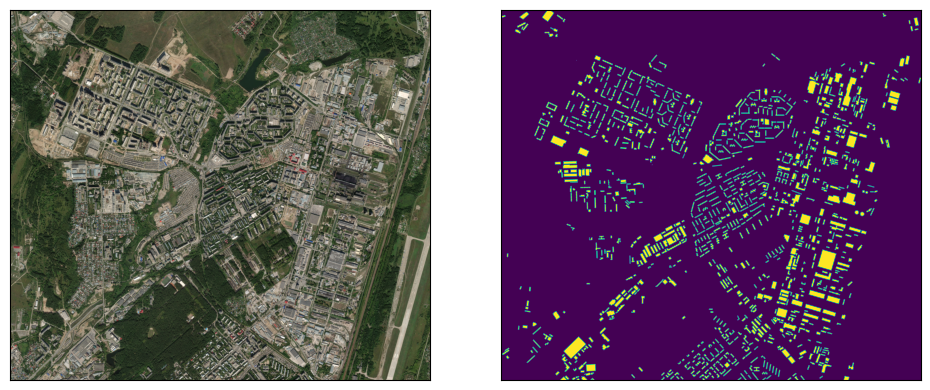

In [121]:
# orig sample
custom_plot(img, mask)

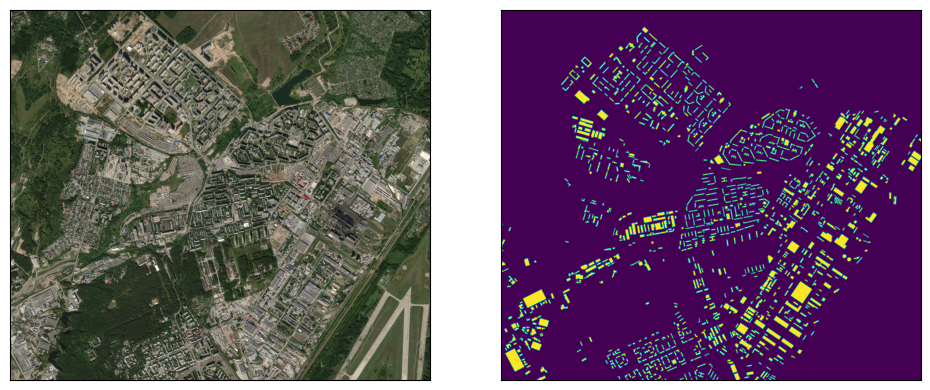

In [136]:
# rotated sample
custom_plot(img_rot, mask_rot)

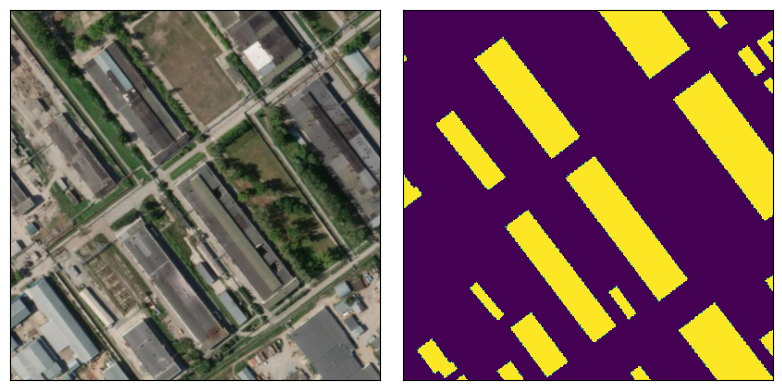

In [124]:
# cropped sample
custom_plot(img_cropped, mask_cropped, size=8)

### Generation of crop dataset (test)

In [20]:
# catalog to save results
save_cat = Path('/home/ezhur/datasets/projects/satellite_datasets/test/')

# orig dataset catalog
cat = Path('/home/ezhur/datasets/projects/train_updated_titles/train_updated_titiles')
img_folder = cat / 'images'
mask_folder = cat / 'masks'

test_nums = [16, 17, 19]    # image numbers for test dataset

for num in test_nums:
    num = f'{num:03d}'
    # open img, mask
    img_name = f'train_image_{num}.png'
    img_path = img_folder / img_name
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_name = f'train_mask_{num}.png'
    mask_path = mask_folder / mask_name
    mask = cv2.imread(str(mask_path), 0)

    img_shape = mask.shape

    for h_crop in range(400, 810, 50):  # size of crop
        # for saving result
        save_img_folder = save_cat / f'images_size_{h_crop}'
        save_img_folder.mkdir(exist_ok=True)
        save_mask_folder = save_cat / f'masks_size_{h_crop}'
        save_mask_folder.mkdir(exist_ok=True)

        # iterate by "windows"
        for height in range(h_crop, img_shape[1], h_crop):
            for width in range(h_crop, img_shape[0], h_crop):
                test_transform = A.Crop(height-h_crop, width - h_crop, height, width, always_apply=True)

                # number of "window"
                num_h = int(height/h_crop)
                num_w = int(width/h_crop)

                save_img_path = save_img_folder / f'{img_name[:-4]}_{num_h}_{num_w}_{h_crop}px.png'
                save_mask_path = save_mask_folder / f'{mask_name[:-4]}_{num_h}_{num_w}_{h_crop}px.png'
                
                test_transformed = test_transform(image=img, mask=mask)
                img_cropped = test_transformed['image']
                mask_cropped = test_transformed['mask']
                
                img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(save_img_path), img_cropped)
                cv2.imwrite(str(save_mask_path), mask_cropped)

